- TODO: Print graph of connections based on users
- TODO: Might need to segment by category - lookup average ratings of items.
- TODO: Use z-scores?
- TODO: User-based modeling, etc...
- TODO: To use Rstudio, make a script which combines businesses/matches/whatever into a single CSV
- TODO: Sentiment analysis

## Setup

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from collections import Counter

random = np.random.RandomState(0)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import scipy.stats

from run_trueskill_mp import convert_matches_format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
businesses = pd.read_pickle('dataset_processed/businesses.pkl')
matches = pd.read_pickle('dataset_processed/matches.pkl')
# Drop draws, for now
matches = matches[matches.win != 0]
matches = convert_matches_format(matches)
wins_counter = np.bincount(matches.b1)
losses_counter = np.bincount(matches.b2)
matches_counter = wins_counter + losses_counter

# Add matches, wins, losses
businesses['matches'] = matches_counter
businesses['wins'] = wins_counter
businesses['losses'] = losses_counter

businesses = businesses.rename(columns={'avg_rating': 'star_rating'})

## Restaurant ranking analyses - message passing inference

In [4]:
mp_samples = np.load('results/mp_dropdraws_20.npy')
ratings, variances = mp_samples[-1, 0, :], mp_samples[-1, 1, :]
n_b = len(ratings)
print("{} ratings ({:.3f}, {:.3f})".format(n_b, ratings.min(), ratings.max()))

businesses['ts_rating'] = ratings
businesses['ts_variance'] = variances
businesses['ranking'] = scipy.stats.rankdata(-ratings)

156638 ratings (-4.466, 4.142)


Plot convergence of a few samples

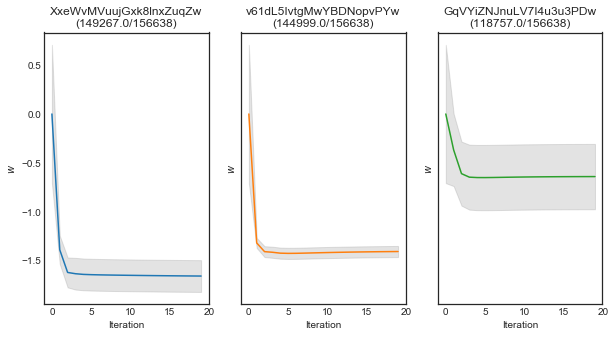

In [7]:
n_sel = 3

sel_bs = random.choice(np.arange(mp_samples.shape[-1]), size=n_sel, replace=False)

color_key = ['#1f77b4', '#ff7f0e', '#2ca02c']
f, figs = plt.subplots(1, n_sel, figsize=(10, 5), sharey = True)
ranks = np.arange(3)

for i, (b_i, fig) in list(enumerate(zip(sel_bs, figs))):
    b_samples = mp_samples[:, :, b_i].squeeze()

    fig.plot(b_samples[:, 0], alpha=1, color=color_key[i], label=b_i)
    fig.fill_between(np.arange(len(b_samples)),
                     b_samples[:, 0] - b_samples[:, 1],
                     b_samples[:, 0] + b_samples[:, 1],
                     color='grey', facecolor='grey', alpha=0.22)
    fig.set_ylabel('$w$')
    fig.set_xlabel('Iteration')
    business_str = businesses.loc[b_i].business_id.decode('utf8')
    business_ranking = businesses.loc[b_i].ranking
    fig.set_title('{}\n({}/{})'.format(business_str, business_ranking, n_b))

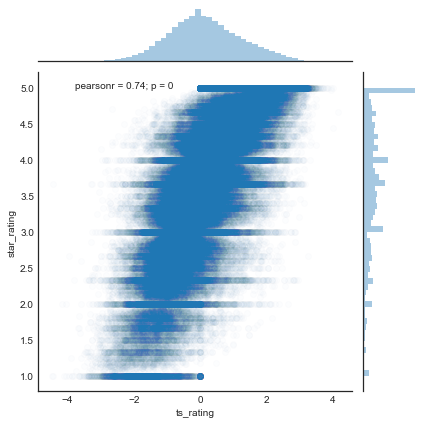

In [8]:
sns.jointplot(x='ts_rating', y='star_rating', data=businesses, alpha=0.01)

In [10]:
print("Max rating:")

(156638,)